IPアドレスと緯度経度が 'latlng_output_lof.csv' に保存されました。
2次元座標プロットが 'coordinates_lof_plot.png' に保存されました。


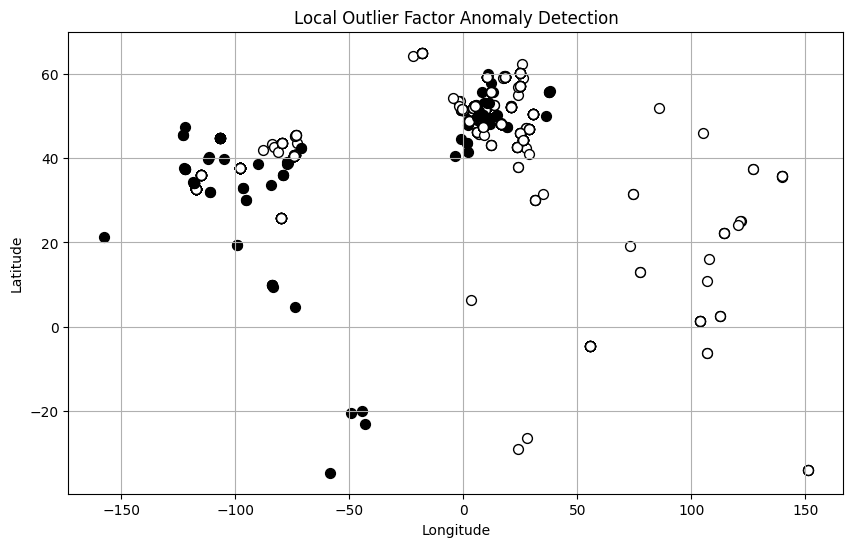

In [1]:
# %% 
import geoip2.database
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

def plot_coordinates_with_lof(csv_file_path, db_path, output_csv_path, output_plot_path):
    # 1. GeoLite2データベースを読み込む
    reader = geoip2.database.Reader(db_path)

    # 2. IPアドレスリストをCSVから読み込む
    data = pd.read_csv(csv_file_path, header=None, names=['ip_address', 'value'])

    # 3. 緯度・経度を取得し、リストに保存する
    locations = []
    output_data = []  # IPアドレス、緯度、経度を保存するリスト
    for ip in data['ip_address']:
        try:
            response = reader.city(ip)
            lat = response.location.latitude
            lon = response.location.longitude
            if lat and lon:
                locations.append([lat, lon])
                # IPアドレス、緯度、経度をリストに追加
                output_data.append([ip, lat, lon])
        except geoip2.errors.AddressNotFoundError:
            pass  # 位置情報が見つからない場合は無視
        except Exception as e:
            print(f"Error retrieving data for IP: {ip} - {e}")

    # データベースを閉じる
    reader.close()

    # 4. データをCSVファイルに保存
    df = pd.DataFrame(output_data, columns=['IP Address', 'Latitude', 'Longitude'])
    df.to_csv(output_csv_path, index=False)
    print(f"IPアドレスと緯度経度が '{output_csv_path}' に保存されました。")

    # 5. Local Outlier Factorによる異常検知
    coordinates = np.array(locations)
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # contaminationは異常の割合
    labels = lof.fit_predict(coordinates)
    anomaly_scores = lof.negative_outlier_factor_  # 各ポイントの異常スコアを取得

    # 6. 異常データと正常データをプロット
    plt.figure(figsize=(10, 6))

    # 正常データは白、異常データは黒でプロット
    for label, xy, score in zip(labels, coordinates, anomaly_scores):
        if label == -1:
            # 異常ポイントは黒
            color = 'k'
        else:
            # 正常ポイントは白
            color = 'w'
        
        plt.scatter(xy[1], xy[0], c=color, marker='o', edgecolors='k', s=50)

    plt.title('Local Outlier Factor Anomaly Detection')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # 7. クラスタリング結果を画像ファイルとして保存
    plt.savefig(output_plot_path)
    print(f"2次元座標プロットが '{output_plot_path}' に保存されました。")

    # 8. プロットを表示
    plt.show()

# 使用例
if __name__ == "__main__":
    csv_file_path = 'input_ips.csv'  # 読み込むIPアドレスのCSVファイル
    db_path = 'GeoLite2-City.mmdb'   # GeoLite2-City.mmdb のファイルパス
    output_csv_path = 'latlng_output_lof.csv'  # 緯度経度を保存するCSVファイル
    output_plot_path = 'coordinates_lof_plot.png'  # 2次元座標プロットを保存する画像ファイル

    plot_coordinates_with_lof(csv_file_path, db_path, output_csv_path, output_plot_path)
